In [189]:
import pandas as pd
import numpy as np

import re
import nltk
import string

from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.feature_extraction.text import CountVectorizer 
vectorizer = CountVectorizer() 
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [164]:
persuasive = pd.read_csv('~/.kaggle/feedback-prize-effectiveness/train.csv')

**first look at data, looks like every body of text is written in different style and servse a different function.**

In [165]:
persuasive.head(10) 

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective


**I suspect that all texts have different rules regarding length and perhaps emotional affect, depending on their "type"**

In [166]:
persuasive['discourse_type'].unique()

array(['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim',
       'Rebuttal', 'Concluding Statement'], dtype=object)

**comparing 2 "lead" type texts, the one graded higher seems more professional. It seems also more better supported by arguments vs more "opinion-like" opener.**

In [167]:
print(persuasive.discourse_text[0])
print('\n')
print(persuasive.discourse_text[9])

Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 


Limiting the usage of cars has personal and professional support all across the globe and yet it has yet to be embraced everywhere. Statistical proof show where it may help and real life examples of some of the effects of reducing, or getting rid of altogether, cars in one's daily life. While "recent studies suggest that Americans are buying fewer cars, driving less and getting fewer licenses as each year goes by" (Source 4), is that really enough or for the right reason? There are plenty of reasons to stop, or limit, the amount of cars being driven on the roads for every kind of person, from the hippie to the businessman, from the mom to the college student. 


**first thing I wanted to do was clean and tokenize the text for later. To do that I have changed all text to lowercase, removed punctuation and stopwords. Afterwards I've lemmitized the remaining text and split it into individual words.

In [168]:
persuasive['discourse_text_processed'] = persuasive['discourse_text'].str.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

persuasive['discourse_text_processed'] = persuasive['discourse_text_processed'].apply(lambda text: remove_punctuation(text))

STOPWORDS = list(stopwords.words('english')) + ['im']

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

persuasive['discourse_text_processed'] = persuasive['discourse_text_processed'].apply(lambda text: remove_stopwords(text))

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

persuasive['discourse_text_processed'] = persuasive['discourse_text_processed'].apply(lambda text: lemmatize_words(text))

def tokkenize(text):
    return text.split()

persuasive['discourse_text_words_tokenized'] = persuasive['discourse_text_processed'].apply(lambda text: tokkenize(text))

**I've decided to quickly check for the words that appear most often. It seems like no obviously useless words remain**

In [169]:
from collections import Counter

cnt = Counter()
for text in persuasive["discourse_text_words_tokenized"].values:
    for word in text:
        cnt[word] += 1
        
cnt.most_common(20)

[('student', 15899),
 ('people', 10853),
 ('would', 10623),
 ('vote', 8730),
 ('school', 8369),
 ('electoral', 7076),
 ('college', 6136),
 ('car', 6067),
 ('one', 5869),
 ('like', 5779),
 ('get', 5777),
 ('time', 5552),
 ('could', 5484),
 ('state', 5366),
 ('make', 5198),
 ('help', 5125),
 ('think', 5091),
 ('also', 4786),
 ('president', 4607),
 ('venus', 4388)]

**When it comes to the length of text, we can see some variation depending on the "type" of text.**

In [170]:
persuasive['entry_length'] = persuasive['discourse_text'].apply(len) 

<AxesSubplot:ylabel='Frequency'>

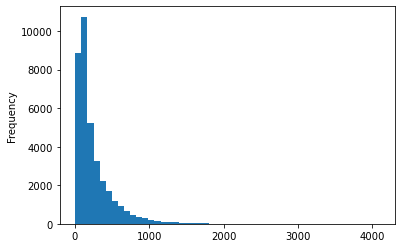

In [171]:
 persuasive['entry_length'].plot(kind = 'hist' , bins = 50) 


Text(0.5, 0.98, 'Length by grade')

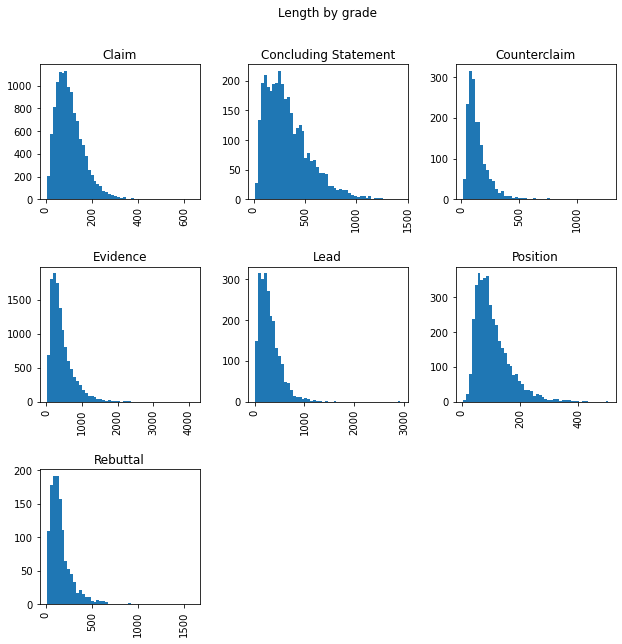

In [172]:
ax = persuasive.hist(column = 'entry_length', by = 'discourse_type', bins = 50 , figsize = (10,10));
pl.suptitle('Length by grade') 

**It seemed possible, that usage of longer, more complicated words might affect the final grade. To check for it I have decided to calculate the mean length of words used in each text.**

In [173]:
def average_word_length(text):
    split_text = []
    for word in text.split():
        if word.isalpha():
            split_text.append(word)
            
    amount = len(split_text)
    length = 0
    
    for word in split_text:
        length += len(word)
    return length/amount if amount!=0 else 0

persuasive['average_word_length'] = persuasive['discourse_text'].apply(lambda text: average_word_length(text))

**Very well put. It seems that the function does not consider some 1 word texts as alphanumerical and tries to divide by 0 to get the mean. It's pretty obviously a mistake, as I doubt anybody would judge a 1 word reply to be "adequate". I have made every such instance to have a mean of 0.0 and removed them from the df.**

In [174]:
persuasive['discourse_text'][11]

'stress. '

In [175]:
persuasive.drop(persuasive[persuasive['average_word_length'] == 0].index, inplace = True)
persuasive.head(12)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_text_processed,discourse_text_words_tokenized,entry_length,average_word_length
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,hi isaac going writing face mar natural landfo...,"[hi, isaac, going, writing, face, mar, natural...",317,3.517241
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,perspective think face natural landform dont t...,"[perspective, think, face, natural, landform, ...",210,3.702703
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,think face natural landform life mar descovere...,"[think, face, natural, landform, life, mar, de...",105,4.000000
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,life mar would know reason think natural landf...,"[life, mar, would, know, reason, think, natura...",362,3.622951
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,people thought face formed alieans thought lif...,"[people, thought, face, formed, alieans, thoug...",101,4.588235
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,though say life mar exist think life mar,"[though, say, life, mar, exist, think, life, mar]",85,3.500000
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,say paragraph 7 april 5 1998 mar global survey...,"[say, paragraph, 7, april, 5, 1998, mar, globa...",201,4.322581
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,everyone thought made alieans even though wasn...,"[everyone, thought, made, alieans, even, thoug...",193,4.333333
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,though people satified landform natural landfo...,"[though, people, satified, landform, natural, ...",225,3.891892
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,limiting usage car personal professional suppo...,"[limiting, usage, car, personal, professional,...",668,4.252427


**It seems that the average word length is slightly higher than 4 and has no significant outliers across all three grades. I don't that there is anything useful to be found here.**

<AxesSubplot:ylabel='Frequency'>

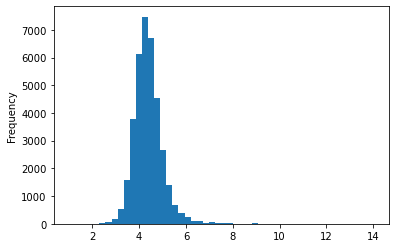

In [176]:
persuasive['average_word_length'].plot(kind = 'hist' , bins = 50) 

Text(0.5, 0.98, 'Length by word length')

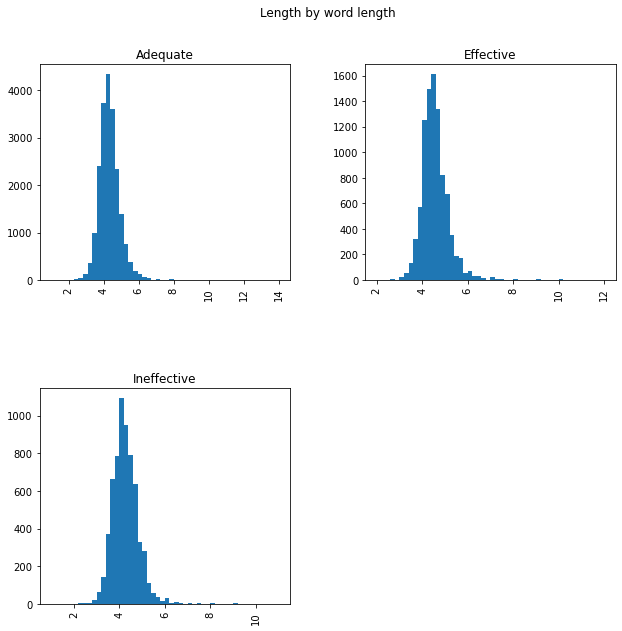

In [177]:
ax = persuasive.hist(column = 'average_word_length', by = 'discourse_effectiveness', bins = 50 , figsize = (10,10));
pl.suptitle('Length by word length') 

**The first model I will try is Naive Bayes, after transforming the text into usable vectors. The accuracy is not great, but I am very happy to have beaten random chance on the first try. It seems that I need to look for some more variables to train the model on**

In [199]:
V = vectorizer.fit_transform(persuasive['discourse_text_processed'])

In [209]:
T = transformer.fit_transform(V)

TypeError: 'tuple' object is not callable

In [208]:
X=T
y=persuasive['discourse_effectiveness']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [205]:
classifier.fit(X_train, y_train)

MultinomialNB()

In [206]:
classifier.score(X_test, y_test) 

0.6207459842090934

In [133]:
test_data = pd.read_csv('~/.kaggle/feedback-prize-effectiveness/test.csv')
test_data.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim
